<a href="https://colab.research.google.com/github/Ghisbe/Alertas_pictogramas/blob/main/Modelo_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Redes neuronales recurrentes.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import Word2Vec
import gdown


Utilizamos dos csv de el pre procesamiento de la columna 'description' e 'instruction' para combinar ambas columnas.

In [4]:
url = "https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu"

In [5]:
output = 'alertas_lemma.csv'
gdown.download(url, output, quiet=False)

# Leer el archivo CSV en un DataFrame de pandas
alertas_description = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu
From (redirected): https://drive.google.com/uc?id=1fs7dmydF11O-rw1xX3ZDZd-7dGew73lu&confirm=t&uuid=a9c8cc3d-5b59-48c3-89e7-7ea2490684bf
To: /content/alertas_lemma.csv
100%|██████████| 143M/143M [00:03<00:00, 44.9MB/s]


In [6]:
alertas_description.head(2)

,id,event,description,instruction,urgency,severity,description_token,description_no_stopwords,lemmatized_description
0,5ed30eb3283336e2e7c8a2a8,Dust Storm Warning,the national weather service in phoenix has is...,Motorists should not drive into a dust storm. ...,Expected,Severe,"['the', 'national', 'weather', 'service', 'in'...","['national', 'weather', 'service', 'phoenix', ...","['national', 'weather', 'service', 'phoenix', ..."
1,5e6daf2c023f1930efa590ce,Tropical Storm Warning,what winds thirty to forty kt and seas five t...,Mariners should alter plans to avoid these haz...,Immediate,Severe,"['what', 'winds', 'thirty', 'to', 'forty', 'kt...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi..."


In [7]:
# descargamos el otro dataset con el procesamiento de 'instruction'
url_instruction = "https://drive.google.com/uc?id=1E2QjfTk4Ke6u1ZEnmsqWHETproJE5zVK"
output_instruction = 'archivo_instruction.csv'
gdown.download(url_instruction, output_instruction, quiet=False)

# Leer el archivo CSV de instruction
instructions = pd.read_csv(output_instruction)

Downloading...
From: https://drive.google.com/uc?id=1E2QjfTk4Ke6u1ZEnmsqWHETproJE5zVK
To: /content/archivo_instruction.csv
100%|██████████| 13.9M/13.9M [00:00<00:00, 60.3MB/s]


In [8]:
instructions.head(2)

,id,event,instruction_token2
0,5ed30eb3283336e2e7c8a2a8,Dust Storm Warning,"['motorist', 'drive', 'dust', 'storm', 'pull',..."
1,5e6daf2c023f1930efa590ce,Tropical Storm Warning,"['mariner', 'alter', 'plan', 'avoid', 'hazardo..."


Unimos los dataframe teniendo en cuanta el ID.

In [9]:
alertas = pd.merge(alertas_description, instructions, on='id')

In [10]:
# Combinar las columnas lematizadas y de instrucciones en una única columna
alertas['combined_text'] = alertas['lemmatized_description'].apply(lambda x: ' '.join(eval(x))) + ' ' + alertas['instruction']

In [11]:
alertas.head(2)

,id,event_x,description,instruction,urgency,severity,description_token,description_no_stopwords,lemmatized_description,event_y,instruction_token2,combined_text
0,5ed30eb3283336e2e7c8a2a8,Dust Storm Warning,the national weather service in phoenix has is...,Motorists should not drive into a dust storm. ...,Expected,Severe,"['the', 'national', 'weather', 'service', 'in'...","['national', 'weather', 'service', 'phoenix', ...","['national', 'weather', 'service', 'phoenix', ...",Dust Storm Warning,"['motorist', 'drive', 'dust', 'storm', 'pull',...",national weather service phoenix issued dust s...
1,5e6daf2c023f1930efa590ce,Tropical Storm Warning,what winds thirty to forty kt and seas five t...,Mariners should alter plans to avoid these haz...,Immediate,Severe,"['what', 'winds', 'thirty', 'to', 'forty', 'kt...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi...","['winds', 'thirty', 'forty', 'kt', 'seas', 'fi...",Tropical Storm Warning,"['mariner', 'alter', 'plan', 'avoid', 'hazardo...",winds thirty forty kt seas five eight ft south...


In [12]:
# Tokenización y padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(alertas['combined_text'])
sequences = tokenizer.texts_to_sequences(alertas['combined_text'])
max_len = 200
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

In [13]:
# Word Embeddings
sentences = [text.split() for text in alertas['combined_text']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, epochs=10)

Visualizar la distribucion de etiquetas.

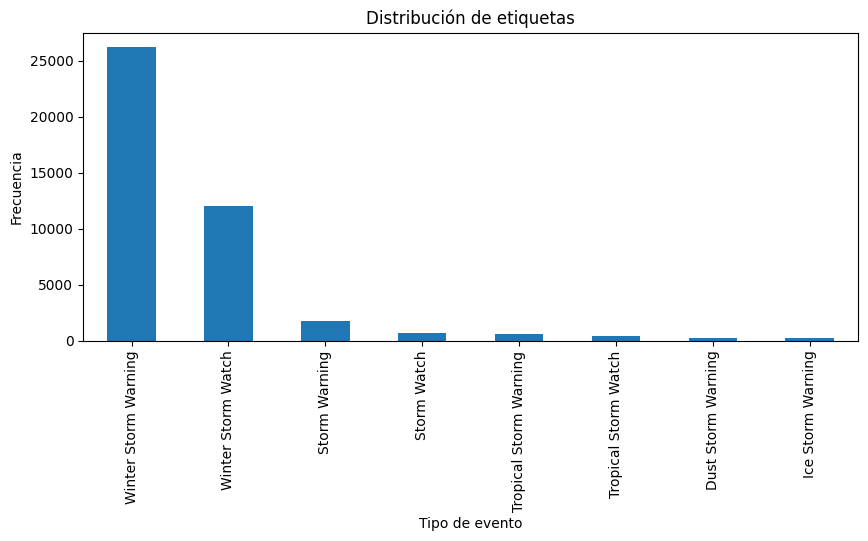

In [14]:
plt.figure(figsize=(10, 4))
alertas['event_x'].value_counts().plot(kind='bar')
plt.title('Distribución de etiquetas')
plt.xlabel('Tipo de evento')
plt.ylabel('Frecuencia')
plt.show()

In [15]:
# Revisión de la consistencia de etiquetas
grupo_evento = alertas.groupby('event_x')
for event, group in grupo_evento:
    print(f"Evento: {event}")
    print(group['combined_text'].head(5))
    print("\n")

Evento: Dust Storm Warning
0     national weather service phoenix issued dust s...
52    national weather service el paso issued dust s...
62    national weather service spokane issued dust s...
63    national weather service spokane issued dust s...
64    national weather service spokane issued dust s...
Name: combined_text, dtype: object


Evento: Ice Storm Warning
5150    significant icing expected total snow accumula...
6093    ice storm warning cancelled longer effect A Wi...
6107    ice storm warning cancelled longer effect A Wi...
6109    significant icing expected total snow accumula...
6153    significant icing expected total snow accumula...
Name: combined_text, dtype: object


Evento: Storm Warning
76     southwest winds fifteen twenty-five kt gusts t...
77     storm warning south winds fifty kts gusts seve...
252    storm warning cancelled longer effect Mariners...
253    storm warning cancelled longer effect Mariners...
255    storm warning cancelled longer effect Mariners

Detectar anomalias.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest

In [17]:
# Convertir descripciones a representaciones numéricas usando TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(alertas['combined_text'])

# Aplicar Isolation Forest para detectar anomalías
clf = IsolationForest(contamination=0.01, random_state=42)
alertas['anomaly'] = clf.fit_predict(X)

# Revisar las anomalías detectadas
anomalies = alertas[alertas['anomaly'] == -1]
print("Anomalías detectadas:")
print(anomalies[['combined_text', 'event_x']])

Anomalías detectadas:
                                           combined_text               event_x
1787   heavy snow strong winds impact northcentral no...  Winter Storm Warning
4367   winter weather warnings advisories extended tu...  Winter Storm Warning
5077   winter weather advisory snow sleet expected to...    Winter Storm Watch
8111   moderate heavy snow expected saturday evening ...    Winter Storm Watch
8582   light moderate snow falling currently colorado...    Winter Storm Watch
...                                                  ...                   ...
41367  strong shear exacting toll guillermo new infor...  Tropical Storm Watch
41372  hilda gradually weakening drawing closer hawai...  Tropical Storm Watch
41494  ignacio rapidly intensifies major hurricane ne...  Tropical Storm Watch
41633  tropical storm niala moving northwestward new ...  Tropical Storm Watch
42050  strong northeasterly gradient place across gre...         Storm Warning

[421 rows x 2 columns]


Eliminar las anomalias.

In [18]:
# Eliminar las filas con anomalías del DataFrame
alertas_cleaned = alertas[alertas['anomaly'] != -1]

print(f"Total de filas después de eliminar anomalías: {len(alertas_cleaned)}")

Total de filas después de eliminar anomalías: 41655


Division de datos para el entrenamiento y validacion.

In [19]:
# Dividir los datos en entrenamiento y validación
train_features, val_features, train_labels, val_labels = train_test_split(
    padded_sequences, alertas['event_x'], test_size=0.2, random_state=42
)

In [20]:
print("Cantidad de datos de entrenamiento:", len(train_features))
print("Cantidad de datos de validación:", len(val_features))

Cantidad de datos de entrenamiento: 33660
Cantidad de datos de validación: 8416


In [21]:
# Codificar las etiquetas
label_encoder_event = LabelEncoder()
train_labels = label_encoder_event.fit_transform(train_labels)
val_labels = label_encoder_event.transform(val_labels)

In [22]:
# Construcción del modelo
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
                    weights=[embedding_matrix], trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, dropout=0.3, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(alertas['event_x'].unique()), activation='softmax'))


In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# Resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          957800    
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
Total params: 1083824 (4.13 MB)
Trainable params: 126024 (492.28 KB)
Non-trainable params: 957800 (3.65 MB)
______________

In [25]:
# Entrenamiento del modelo
history = model.fit(train_features, np.array(train_labels),
                    validation_data=(val_features, np.array(val_labels)),
                    epochs=20, batch_size=16)

Epoch 1/20
2104/2104 [==============================] - 331s 156ms/step - loss: 0.6236 - accuracy: 0.7942 - val_loss: 0.2801 - val_accuracy: 0.9193
Epoch 2/20
2104/2104 [==============================] - 316s 150ms/step - loss: 0.2453 - accuracy: 0.9239 - val_loss: 0.1908 - val_accuracy: 0.9457
Epoch 3/20
2104/2104 [==============================] - 315s 150ms/step - loss: 0.1918 - accuracy: 0.9425 - val_loss: 0.1501 - val_accuracy: 0.9575
Epoch 4/20
2104/2104 [==============================] - 320s 152ms/step - loss: 0.1565 - accuracy: 0.9527 - val_loss: 0.1058 - val_accuracy: 0.9661
Epoch 5/20
2104/2104 [==============================] - 347s 165ms/step - loss: 0.1144 - accuracy: 0.9629 - val_loss: 0.0833 - val_accuracy: 0.9696
Epoch 6/20
2104/2104 [==============================] - 341s 162ms/step - loss: 0.0939 - accuracy: 0.9691 - val_loss: 0.0776 - val_accuracy: 0.9729
Epoch 7/20
2104/2104 [==============================] - 311s 148ms/step - loss: 0.0865 - accuracy: 0.9705 - val_

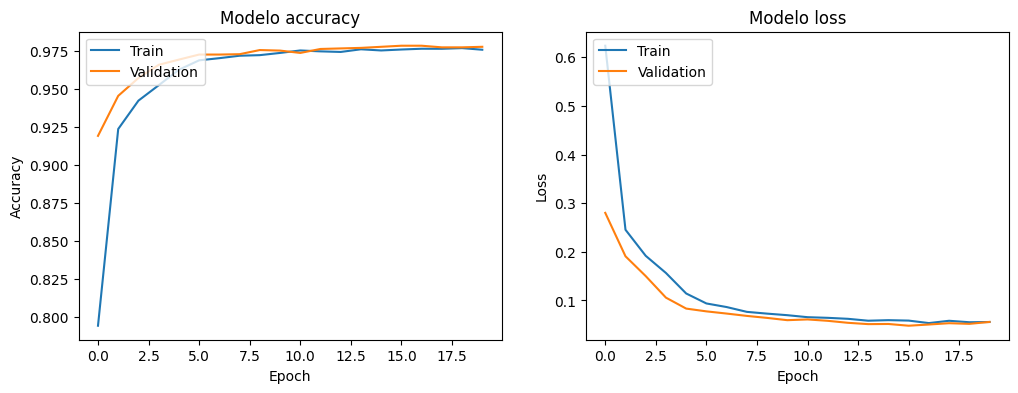

In [26]:
# Visualización del entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modelo accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Modelo loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
# Evaluación del modelo
loss, accuracy = model.evaluate(val_features, np.array(val_labels))
print(f'Loss: {loss}, Accuracy: {accuracy}')


263/263 [==============================] - 31s 116ms/step - loss: 0.0559 - accuracy: 0.9780
Loss: 0.05587208271026611, Accuracy: 0.978018045425415


In [28]:
# Matriz de confusión y reporte de clasificación
val_predictions = model.predict(val_features)
val_predictions = np.argmax(val_predictions, axis=1)
cm = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix:")
print(cm)


263/263 [==============================] - 29s 108ms/step
Confusion Matrix:
[[  45    0    0    0    0    0    0    0]
 [   0   47    0    0    0    0    4    0]
 [   0    0  387    0    3    0    0    0]
 [   0    0    3  112    0    1    0    0]
 [   0    0    2    0  107    1    0    0]
 [   0    0    0    1    2   62    0    1]
 [   0    1    0    0    0    0 5212   62]
 [   0    0    0    0    0    0  104 2259]]


In [29]:
print("Classification Report:")
print(classification_report(val_labels, val_predictions, target_names=label_encoder_event.classes_))

Classification Report:
                        precision    recall  f1-score   support

    Dust Storm Warning       1.00      1.00      1.00        45
     Ice Storm Warning       0.98      0.92      0.95        51
         Storm Warning       0.99      0.99      0.99       390
           Storm Watch       0.99      0.97      0.98       116
Tropical Storm Warning       0.96      0.97      0.96       110
  Tropical Storm Watch       0.97      0.94      0.95        66
  Winter Storm Warning       0.98      0.99      0.98      5275
    Winter Storm Watch       0.97      0.96      0.96      2363

              accuracy                           0.98      8416
             macro avg       0.98      0.97      0.97      8416
          weighted avg       0.98      0.98      0.98      8416



Prediccion con en relacion a la descripcion y el evento.

In [30]:
# Función predict
def predict(texts, tokenizer, model, max_len, eventos):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    predictions = model.predict(padded_sequences)
    predicted_events = [eventos[np.argmax(prediction)] for prediction in predictions]
    return predicted_events


In [31]:
# Función random_prediction
def random_prediction(alertas, n=1, tokenizer=None, model=None, max_len=None):
    # Extraer eventos únicos directamente del DataFrame
    eventos = alertas['event_x'].unique()

    random_indices = np.random.choice(alertas.index, size=n, replace=False)  # Seleccionar índices aleatorios
    random_descriptions = alertas.loc[random_indices, 'combined_text'].values  # Usar la columna combined_text
    predictions = predict(random_descriptions, tokenizer, model, max_len, eventos)
    result = list(zip(random_descriptions, predictions))  # Emparejar descripciones y predicciones
    return result

In [34]:
# Llamar a la función random_prediction
predictions = random_prediction(alertas, n=1, tokenizer=tokenizer, model=model, max_len=max_len)
for combined_text, prediction in predictions:
    print(f'Description: {combined_text}')
    print(f'Prediction: {prediction}')

1/1 [==============================] - 0s 105ms/step
Description: heavy snow expected travel difficult impossible total snow accumulations six inches expected chukchi sea coast midnight six monday additional details snow expected develop become heavy midnight tonight continue monday morning A Winter Storm Warning for snow and blowing snow means severe
winter weather conditions are expected. This will make travel
very difficult or impossible.
Prediction: Storm Watch


#Creacion de pictogramas.

Un pictograma es un símbolo gráfico que transmite información o datos mediante una representación clara y simplificada ya que, ayudan a transmitir información de forma visual y más rápida.

In [ ]:
!pip install pillow

In [63]:
import cv2

In [64]:
def create_pictogram(description, event):
    # Crear una imagen en blanco
    img = np.ones((500, 500, 3), dtype=np.uint8) * 255

    # Definir colores
    color_nube = (192, 192, 192)
    color_rayo = (255, 255, 0)  # Amarillo

    # Dibujar el pictograma basado en el evento
    if event == 'Dust Storm Warning':
        # Triángulo blanco con bordes rojos
        points = np.array([[150, 400], [350, 400], [250, 150]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(img, [points], (255, 255, 255))
        cv2.polylines(img, [points], True, (0, 0, 255), 5)
        # Nube gris en el centro
        cv2.circle(img, (250, 275), 80, color_nube, -1)
        cv2.circle(img, (350, 200), 60, color_nube, -1)
        cv2.circle(img, (450, 350), 70, color_nube, -1)
        # Asteriscos marrones dentro del triángulo
        for _ in range(100):
            x1 = np.random.randint(150, 350)
            y1 = np.random.randint(150, 400)
            if cv2.pointPolygonTest(points, (x1, y1), False) >= 0:
                cv2.putText(img, "*", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (165, 42, 42), 1, cv2.LINE_AA)
    elif event == 'Tropical Storm Warning':
        # Triángulo rojo con centro blanco
        points = np.array([[100, 400], [400, 400], [250, 100]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(img, [points], (0, 0, 255))
        cv2.polylines(img, [points], True, (0, 0, 0), 5)
        # Espiral negra en el centro
        x_center, y_center = 250, 250
        for i in range(20, 220, 20):
            cv2.ellipse(img, (x_center, y_center), (i, i), 0, 0, 360, (0, 0, 0), 2)
        # Rayos azules
        cv2.line(img, (200, 200), (100, 400), color_rayo, 5)
        cv2.line(img, (300, 300), (400, 400), color_rayo, 5)
    elif event in ['Winter Storm Warning', 'Ice Storm Warning']:
        # Triángulo blanco con bordes rojos
        points = np.array([[100, 400], [400, 400], [250, 100]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(img, [points], (255, 255, 255))
        cv2.polylines(img, [points], True, (0, 0, 255), 5)
        # Nube blanca con bordes negros en el centro
        cv2.circle(img, (250, 275), 80, (255, 255, 255), -1)
        cv2.circle(img, (350, 200), 60, (0, 0, 0), 4)
        cv2.circle(img, (450, 350), 70, (0, 0, 0), 4)
        # Asteriscos azules dentro del triángulo
        for _ in range(50):
            x1 = np.random.randint(100, 400)
            y1 = np.random.randint(100, 400)
            if cv2.pointPolygonTest(points, (x1, y1), False) >= 0:
                cv2.putText(img, "*", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    elif event == 'Winter Storm Watch':
        # Triángulo blanco con bordes amarillos
        points = np.array([[100, 400], [400, 400], [250, 100]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(img, [points], (255, 255, 255))
        cv2.polylines(img, [points], True, (0, 255, 255), 5)
        # Nube blanca con bordes negros en el centro
        cv2.circle(img, (250, 275), 80, (255, 255, 255), -1)
        cv2.circle(img, (350, 200), 60, (0, 0, 0), 4)
        cv2.circle(img, (450, 350), 70, (0, 0, 0), 4)
        # Asteriscos azules dentro del triángulo
        for _ in range(50):
            x1 = np.random.randint(100, 400)
            y1 = np.random.randint(100, 400)
            if cv2.pointPolygonTest(points, (x1, y1), False) >= 0:
                cv2.putText(img, "*", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    elif event == 'Tropical Storm Watch':
        # Triángulo blanco con bordes amarillos
        points = np.array([[100, 400], [400, 400], [250, 100]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(img, [points], (255, 255, 255))
        cv2.polylines(img, [points], True, (0, 255, 255), 5)
        # Espiral negra en el centro
        x_center, y_center = 250, 250
        for i in range(20, 220, 20):
            cv2.ellipse(img, (x_center, y_center), (i, i), 0, 0, 360, (0, 0, 0), 2)
    elif event == 'Storm Watch':
        # Triángulo blanco con bordes amarillos
        points = np.array([[100, 400], [400, 400], [250, 100]], np.int32)
        points = points.reshape((-1, 1, 2))
        cv2.fillPoly(img, [points], (255, 255, 255))
        cv2.polylines(img, [points], True, (0, 255, 255), 5)


    # Mostrar la imagen utilizando matplotlib
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

Descripción: heavy snow likely total snow accumulations greater six inches across watch area snow accumulations greater twelve inches possible much western upper michigan especially higher terrain winds could gust high forty-five mph especially near lake superior shoreline portions central upper western upper michigan sunday afternoon tuesday morning impacts travel could difficult patchy blowing snow could significantly reduce visibility hazardous conditions could impact morning evening commute monday wet slushy snow along strong winds could lead scattered power outages monday Monitor the latest forecasts for updates on this situation.
Evento: Winter Storm Watch


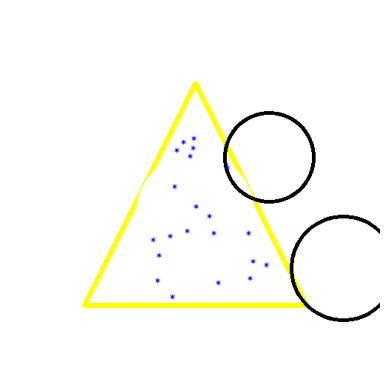

In [65]:
# Obtener la descripción y el evento de una fila en el dataframe
row_index = 750 # Índice numérico de la fila en el dataframe
description = alertas.iloc[row_index]['combined_text']
event = alertas.iloc[row_index]['event_x']

# Descripción y el evento para verificar
print("Descripción:", description)
print("Evento:", event)

# Crear el pictograma
create_pictogram(description, event)


In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

In [ ]:
def create_pictogram(description, event):
    # Crear una imagen en blanco
    img = Image.new('RGB', (300, 300), color=(255, 255, 255))
    d = ImageDraw.Draw(img)

    # Definir la fuente
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except IOError:
        font = ImageFont.load_default()

    # Dibujar el pictograma basado en el evento
    if event == 'Dust Storm Warning':
        # Triángulo blanco con bordes rojos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="red", width=3)
        # Asteriscos amarillos
        for _ in range(50):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="yellow", font=font)
    elif event == 'Tropical Storm Warning':
        # Triángulo rojo con centro blanco
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="red", outline="black")
        d.polygon([(120, 140), (180, 140), (150, 90)], fill="white", outline="black")
        # Espiral
        x_center, y_center = 150, 150
        for i in range(10, 110, 10):
            d.ellipse([(x_center - i, y_center - i), (x_center + i, y_center + i)], outline="black")
    elif event == 'Winter Storm Warning' or event == 'Ice Storm Warning':
        # Triángulo blanco con bordes rojos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="red", width=3)
        # Asteriscos de color azul (simulando nieve)
        for _ in range(30):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="blue", font=font)
    elif event == 'Winter Storm Watch':
        # Triángulo blanco con bordes amarillos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="yellow", width=3)
        # Asteriscos de color azul (simulando nieve)
        for _ in range(30):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            d.text((x1, y1), "*", fill="blue", font=font)
    elif event == 'Tropical Storm Watch':
        # Triángulo blanco con bordes amarillos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="yellow", width=3)
        # Espiral
        x_center, y_center = 150, 150
        for i in range(10, 110, 10):
            d.ellipse([(x_center - i, y_center - i), (x_center + i, y_center + i)], outline="black")
    elif event == 'Storm Watch':
        # Triángulo blanco con bordes amarillos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="yellow", width=3)
        # Líneas entrecortadas azules simulando rayos de tormenta
        for _ in range(100):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = np.random.randint(0, 300)
            y2 = np.random.randint(0, 300)
            d.line((x1, y1, x2, y2), fill="black", width=2)
    elif event == 'Storm Warning':
        # Triángulo blanco con bordes rojos
        d.polygon([(100, 150), (200, 150), (150, 50)], fill="white", outline="red", width=3)
        # Líneas entrecortadas azules simulando rayos de tormenta
        for _ in range(100):
            x1 = np.random.randint(0, 300)
            y1 = np.random.randint(0, 300)
            x2 = np.random.randint(0, 300)
            y2 = np.random.randint(0, 300)
            d.line((x1, y1, x2, y2), fill="black", width=2)

    # Convertir la imagen a un array numpy
    img_array = np.array(img)

    # Mostrar la imagen utilizando matplotlib
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()


Descripción:  snow showers for higher mountain elevations into tuesday   late season pacific storm will continue to bring periods of moderate snow showers to the higher elevations of the sierra nevada into tuesday  travel into the sierra should be avoided during this time with periods as slick roads lowered visibility travel delays and chain controls are expected   what heavy snow occurring plan on difficult travel conditions including during the evening commute on tuesday additional snow accumulations of up to one inch are expected   where west slope northern sierra nevada   when until five pm tuesday   additional details be prepared for significant reductions in visibility at times
Evento: Winter Storm Warning


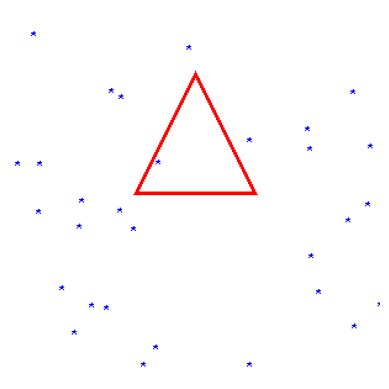

In [ ]:
#obtener la descripción y el evento de una fila en el dataframe
row_index = 4  # Índice numérico de la fila en el dataframe
description = alertas.iloc[row_index]['description']
event = alertas.iloc[row_index]['event']

#descripción y el evento para verificar
print("Descripción:", description)
print("Evento:", event)

#Crear el pictograma
create_pictogram(description, event)